In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
data_dir="/content/drive/MyDrive/ML_Project/ML_DF.csv"
knn_df= pd.read_csv(data_dir)
knn_df

,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,trip_type_Street-hail,refund_neg_duplicated_True,trip_price,trip_duration,Day,Hour
0,225,220,1,0.00,2.5,0.5,999.0,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,22.0,1,0
1,43,43,1,0.81,4.5,0.5,0.5,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,187.0,1,1
2,79,61,1,4.97,18.0,0.5,0.5,3.86,0.0,0.3,...,0,0,0,1,1,0,high,1139.0,1,0
3,160,189,1,0.83,5.5,0.5,0.5,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,242.0,1,1
4,112,117,1,4.99,16.0,0.5,0.5,2.00,0.0,0.3,...,0,0,0,1,1,0,high,999.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913212,37,164,1,1.39,8.0,0.5,0.5,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,595.0,31,23
913213,139,108,1,2.51,11.0,0.5,0.5,1.70,0.0,0.3,...,0,0,0,1,1,0,medium,814.0,31,23
913214,105,138,1,1.00,6.5,0.5,0.5,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,367.0,31,0
913215,105,21,1,2.18,10.0,0.5,0.5,0.00,0.0,0.3,...,0,0,0,1,1,0,medium,637.0,31,23


### We will create two KNN models, one with the euclidean distance and the other with the mahalnobis distance. To compare between both correctly, we will scale the dataset first then create and train the models.

### First, we will start with the eculidean distance.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

#Divide the df into input and output sets
X = knn_df.drop(columns=['trip_price'])
y = knn_df['trip_price']

#Random Sampling
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

#Define the sizes for train(60%), cross-validation(20%), and test(20%) sets
train_size = 0.6
cv_size = 0.2
test_size = 0.2

#Split the dataset into train, CV, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffle, y_shuffle, train_size=train_size, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + cv_size), random_state=42)


#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

#Initialize variables
best_k_euclidean = None
shortest_interval_width = float('inf') #to record the shortest confidence interval
final_accuracy_test = None

#Define the range of k values
k_range = range(1,20,2)

# Initialize lists to store k values and corresponding CV error rates
k_values = []
cv_max_errors = []
cv_min_errors = []

for k in k_range:
    cv_errors = [] #stores cv error rate for each fold

    #Initialize and train the KNN model using the training data and euclidean distance
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)

    #Perform 5-fold cross validation on the model
    scores = cross_val_score(model, X_cv_scaled, y_cv, cv=5, n_jobs=-1)
    #returns an array of scores where each score represents the accuracy of the model on each fold
    cv_errors.extend(1 - scores) #1 - scores = error rate for each fold

    #Get the minimum and maximum CV errors to get the confidence interval
    max_error_cv = max(cv_errors)
    min_error_cv = min(cv_errors)

    interval_width = max_error_cv - min_error_cv

    #Update the best k if this interval is the shortest
    if interval_width < shortest_interval_width:
        shortest_interval_width = interval_width
        best_k_euclidean = k

    #Store each k with its cv error rate for observation
    k_values.append(k)
    cv_max_errors.append(max_error_cv)
    cv_min_errors.append(min_error_cv)

    print(f"Maximum CV Error for k={k}: {max_error_cv}")
    print(f"Minimum CV Error for k={k}: {min_error_cv}")
    print(f"Width of Confidence Interval for k={k}: {interval_width}")

#Print the best k with the shortest confidence interval
print(f"Best k with Shortest Confidence Interval: {best_k_euclidean}")

# Calculate the test data accuracy using the best k observed on the CV data
final_model = KNeighborsClassifier(n_neighbors=best_k_euclidean)
final_model.fit(X_train_scaled, y_train)
y_test_pred_euclidean = final_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred_euclidean)
print(f"Accuracy test: {accuracy_test}")

Maximum CV Error for k=1: 0.04407457088888278
Minimum CV Error for k=1: 0.042925974594831384
Width of Confidence Interval for k=1: 0.001148596294051396
Maximum CV Error for k=3: 0.039557611760519085
Minimum CV Error for k=3: 0.03824463425317559
Width of Confidence Interval for k=3: 0.0013129775073434935
Maximum CV Error for k=5: 0.03780661410424879
Minimum CV Error for k=5: 0.03701168934271404
Width of Confidence Interval for k=5: 0.0007949247615347543
Maximum CV Error for k=7: 0.0376423565484012
Minimum CV Error for k=7: 0.0368748117933696
Width of Confidence Interval for k=7: 0.0007675447550316017
Maximum CV Error for k=9: 0.03755919954009146
Minimum CV Error for k=9: 0.036053546497303524
Width of Confidence Interval for k=9: 0.0015056530427879355
Maximum CV Error for k=11: 0.03824463425317559
Minimum CV Error for k=11: 0.036053546497303524
Width of Confidence Interval for k=11: 0.0021910877558720676
Maximum CV Error for k=13: 0.03818988173455984
Minimum CV Error for k=13: 0.03646417

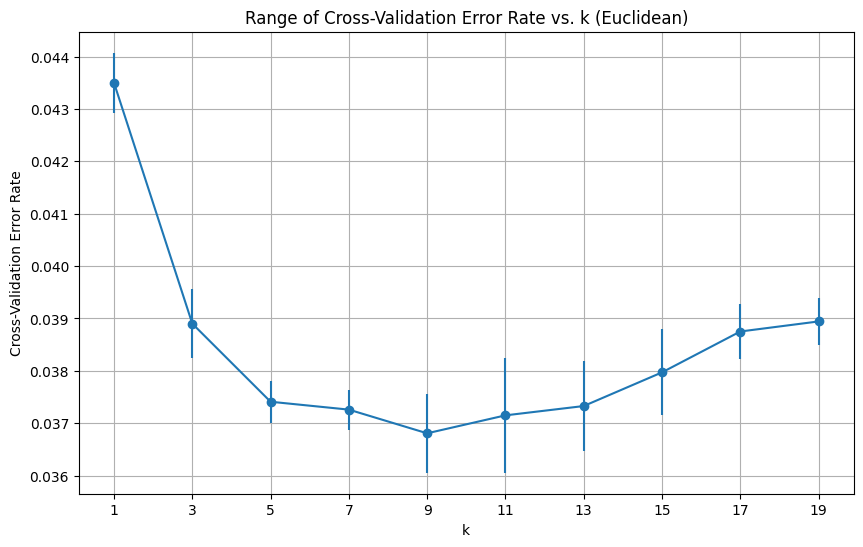

In [ ]:
#Plot the CV error rates vs. k
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, [(a + b) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], yerr=[abs(b - a) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], fmt='o', linestyle='-')
plt.title('Range of Cross-Validation Error Rate vs. k (Euclidean)')
plt.xlabel('k')
plt.ylabel('Cross-Validation Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### We will do the same using the mahalnobis distance

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

#Sample the data for quicker testing
knn_df_sampled = knn_df.sample(frac=0.1, random_state=42)

#Divide the df into input and output sets
X = knn_df_sampled.drop(columns=['trip_price'])
y = knn_df_sampled['trip_price']


#Check for NaN or infinite values
assert not X.isnull().values.any(), "Data contains NaN values"
assert np.isfinite(X.values).all(), "Data contains infinite values"

#Random Sampling
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

#Define the sizes for train(60%), cross-validation(20%), and test(20%) sets
train_size = 0.6
cv_size = 0.2
test_size = 0.2

#Split the dataset into train, CV, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffle, y_shuffle, train_size=train_size, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + cv_size), random_state=42)

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

#Calculate the covariance matrix of the training data
epsilon = 1e-10  #small regularization term
cov_matrix = np.cov(X_train, rowvar=False) + epsilon * np.eye(X_train.shape[1])
inv_cov_matrix = np.linalg.inv(cov_matrix)

#Initialize variables to store results
best_k_mahalanobis = None
shortest_interval_width = float('inf')
final_accuracy_test = None

# Define the range of k values
k_range = range(1, 20, 2)

#Initialize lists to store k values and corresponding CV error rates
k_values = []
cv_max_errors = []
cv_min_errors = []

for k in k_range:
    cv_errors = []

    #Initialize and train the KNN model with Mahalanobis distance
    model = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': inv_cov_matrix})
    model.fit(X_train_scaled, y_train)

    #Perform 5-fold cross validation
    scores = cross_val_score(model, X_cv_scaled, y_cv, cv=5)
    #returns an array of scores where each score represents the accuracy of the model on each fold
    cv_errors.extend(1 - scores)  # 1 - scores = error rate for each fold

    #Calculate minimum and maximum CV errors to get the confidence interval
    max_error_cv = max(cv_errors)
    min_error_cv = min(cv_errors)

    interval_width = max_error_cv - min_error_cv

    #Update the best k if this interval is the shortest
    if interval_width < shortest_interval_width:
        shortest_interval_width = interval_width
        best_k_mahalanobis = k

    #Store k and corresponding CV error
    k_values.append(k)
    cv_max_errors.append(max_error_cv)
    cv_min_errors.append(min_error_cv)

    print(f"Maximum CV Error for k={k}: {max_error_cv}")
    print(f"Minimum CV Error for k={k}: {min_error_cv}")
    print(f"Width of Confidence Interval for k={k}: {interval_width}")

#Print the best k with the shortest confidence interval
print(f"Best k with Shortest Confidence Interval: {best_k_mahalanobis}")

# Calculate the test accuracy on the test data using the best k observed using the CV data
final_model = KNeighborsClassifier(n_neighbors=best_k_mahalanobis, metric='mahalanobis', metric_params={'VI': inv_cov_matrix})
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy test: {accuracy_test}")

Maximum CV Error for k=1: 0.1021078565562551
Minimum CV Error for k=1: 0.0873254859019984
Width of Confidence Interval for k=1: 0.014782370654256693
Maximum CV Error for k=3: 0.09307418560087599
Minimum CV Error for k=3: 0.07664932931836843
Width of Confidence Interval for k=3: 0.01642485628250756
Maximum CV Error for k=5: 0.08759923350670684
Minimum CV Error for k=5: 0.08075554338899538
Width of Confidence Interval for k=5: 0.006843690117711465
Maximum CV Error for k=7: 0.08871851040525736
Minimum CV Error for k=7: 0.08075554338899538
Width of Confidence Interval for k=7: 0.00796296701626198
Maximum CV Error for k=9: 0.09337349397590367
Minimum CV Error for k=9: 0.08623049548316453
Width of Confidence Interval for k=9: 0.007142998492739139
Maximum CV Error for k=11: 0.09362168081029287
Minimum CV Error for k=11: 0.08842047632083216
Width of Confidence Interval for k=11: 0.005201204489460709
Maximum CV Error for k=13: 0.09745414727621138
Minimum CV Error for k=13: 0.09061045715849991
W

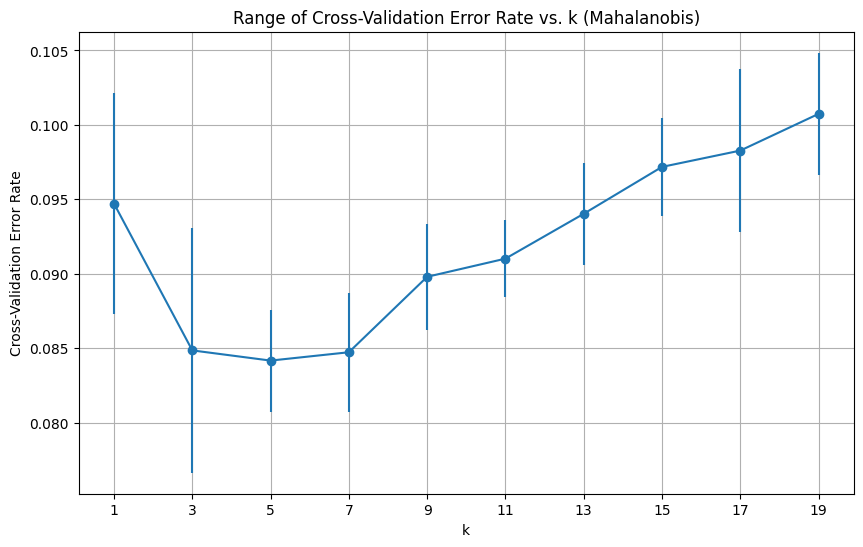

In [ ]:
# Plot the CV error rates
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, [(a + b) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], yerr=[abs(b - a) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], fmt='o', linestyle='-')
plt.title('Range of Cross-Validation Error Rate vs. k (Mahalanobis)')
plt.xlabel('k')
plt.ylabel('Cross-Validation Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### According to the CV errors and the confidence interval: euclidean distance yeilded the best k=7, with interval width= 0.000767; mahalanobis distance yeilded the best k=11 with interval width=0.00520


### This shows that the euclidean distance has a shorter confidence interval than the mahalnobis, hence it has lower error(higher accuracy). So, our final model will be that of the euclidean with k=7 and accuracy of 0.97



Confusion Matrix:
[[ 40258    245   2947]
 [   823   6113      0]
 [  1274      2 130982]]


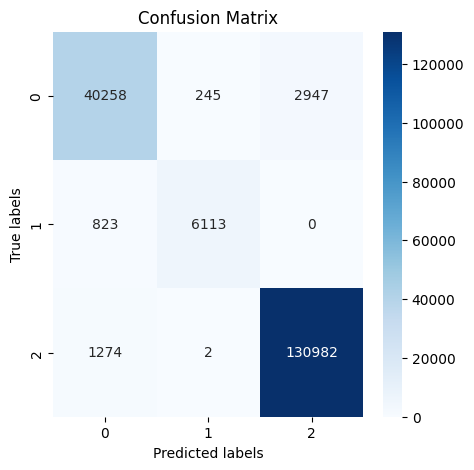

Classification Report:
              precision    recall  f1-score   support

        high       0.95      0.93      0.94     43450
         low       0.96      0.88      0.92      6936
      medium       0.98      0.99      0.98    132258

    accuracy                           0.97    182644
   macro avg       0.96      0.93      0.95    182644
weighted avg       0.97      0.97      0.97    182644



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_euclidean)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the classification report
class_report = classification_report(y_test, y_test_pred_euclidean)
print("Classification Report:")
print(class_report)

### It can be observed that for the "high" and "medium" classes, the precision and recall are almost the same for each one of them. This shows that the model can correctly predict these classes most of the time. But, for the "low" class, the model correctly predicts 88% of all the "low" labels. So, the model needs to see more "low" labeled data to increase the probability of predicting the "low" class correctly.